# <center> STA663 Final Project: Scalable K-means
### <center> Xin Xu, Fu Wen

## <center> Abstract 

Due to its simplicity, the k-means algorithm is one of the most famous machine learning algorithms used to cluster data[1]. The main critical problem of this algorithm is that it might be blocked locally based on the initial random chosen centers. The k-means++ algorithm is developed to solve this problem, spreading out the initial centers with an updating non-uniform distribution. However, K-means++ has a limited applicability to large data sets due to its inherent sequential nature, which requires k passes through the whole data set to find the optimal initialization of centers. The K-means|| algorithm in the paper "Scalable K-Means++" is the parallel version of the k-means++[2] and an improvement. Instead of sampling a single point, it oversamples a couple of centers in each iteration and guarantees the performance at the same time. In this report, we firstly implemented the K-means|| algorithm in Python. Then, we parallelized the algorithm in Spark and applied it to the GAUSSMIXTURE dataset simulated as in [1] and the SPAM dataset from UC Irvine Machine Learning repository [3]. In the end, we compared the clustering cost and convergence speed with the k-means|| algorithm to the result of the k-means and the k-means++.

## 1. Introduction

### 1.1 Background and Related Algorithm

As one of the most popular clustering algorithms, the k-means algorithm has been widely used for the last half of the century[4]. The main idea is to randomly choose k centers, repeatedly assign each point to its nearest center and calculate the new centers by minimizing the sum of the squares of the distance in its neighborhood.

The k-means algorithm has a critical problem of unreliable initialization[2]. This algorithm with an incorrect initialization cannot find a globally optimal solution but rests on a locally optimal solution. In addition, the running time before convergence is long. K-means++ algorithm avoids this problem by finding k better initial centers. It first samples one random point uniformly from the data, then sets the subsequent k-1 centers with probability proportional to its contribution to the overall error given the previous centers. In contrast to the k-means algorithm, k-means++ reduces the probability of picking several initial centers in one cluster. However, the sequence initialization process also limits its applicability to large data sets or data with large k since the whole algorithm is not scalable.

Bahmani et al. constructed the scalable k-means++ algorithm (k-means|| algorithm) in their paper "Scalable K-Means++"[1]. The main idea is to sample more than one point (O(k)) in each round and repeat the process for fewer iterations (O(logn)). Then, the algorithm reclusters the O(klogn) points generated from the above process into k initial centers.



### 1.2 Notation and the Algorithm

Suppose $X = \{x_1, \dots, x_n \}$ are d-dimentional points to be clustered and k is the number of cluster (a positer integer). 

For a subset $Y \in X$, define the distance from a point $x$ to $Y$ as $d(x,Y) = min_{y \in Y} \| x-y\|$, where $\|x -y \|$denote the Euclidean distance between $x$ and $y$, define the centroid of $Y$ as
$$Centroid(Y) = \frac{1}{|Y|} \sum_{y \in Y} y$$

For a set of cluster centers $C = \{ c_1, c_2 ,\dots , c_k\}$, define the _cost of $Y$_ with respect to $C$ as:

$$ \phi_Y(C) = \sum_{y \in Y} d(y,C)^2$$

In k-means|| algorithm, it set an oversampling factor $l = \Omega (k)$. $l>1$ is an integer.

1. Sample a point uniformaly from X as the first center $C$
2. Compute the cost of clustering based on this choice $\phi_{X}(C)=\psi$
3. for $O(log\psi)$ times repeat:  
a. Independently sample $l$ points with probability $p_{x}=\frac{l\cdot d^{2}(x,C)}{\phi_{X}(C)}$ as $C'$
b. $C=C\cup C'$
4. For each point $x \in C$, compute $w_{x}$ as the number of points in $X$ closer to x than other point in $C$
5. Get k clusters from reclustering those weighted points in $C$ 

## Implementation

### Simulate Data 

To generate the dataset GAUSSMIXTURE, we sampled k=5 centers from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance $R\in \{1,10,100 \}$ and then added points from Gaussian distributions with unit variance around each center.

In [4]:
## Simulate data
k = 20
n = 10000
d = 15

## simulate k centers from 15-dimensional spherical Gaussian distribution 
mean = np.hstack(np.zeros((d,1)))
cov = np.diag(np.array([1,10,100]*5))
centers = np.random.multivariate_normal(mean, cov, k)

## Simulate n data
for i in range(k):
    mean = centers[i]
    if i == 0:
        data = np.random.multivariate_normal(mean, np.diag(np.ones(d)), int(n/k+n%k))
        trueLabels = np.repeat(i,int(n/k+n%k))
    else:
        data = np.append(data, np.random.multivariate_normal(mean, np.diag(np.ones(d)) , int(n/k)), axis = 0) 
        trueLabels = np.append(trueLabels,np.repeat(i,int(n/k)))

### K-Means 

In [2]:
def KMeans(data, k, centroids, max_iter = 10000): 
    
    """ Apply the KMeans clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
      centroids                   initial centroids
    
    Returns:
      "Iteration before Coverge"  time used to converge
      "Centroids"                 the final centroids finded by KMeans    
      "Labels"                    the cluster of each data   
    """
    
    n = data.shape[0] 
    iterations = 0
    
    while iterations < max_iter:        
        ## calculate distence between each point to the three centroids
        dist = np.sum((data[:, np.newaxis, :] - centroids)**2, axis=2)
        
        ## give cluster label to each point 
        cluster_label = np.argmin(dist, axis=1)
        
        ## calculate new centroids
        newCentroids = np.zeros(centroids.shape)
        for j in range(0, k):
            if sum(cluster_label == j) == 0:
                newCentroids[j] = centroids[j]
            else:
                newCentroids[j] = np.mean(data[cluster_label == j, :], axis=0)
        
        ## Check if it is converged
        if np.array_equal(centroids, newCentroids):
            print("Converge")
            break 
            
        centroids = newCentroids
        iterations += 1
        
    return({"Iteration before Coverge": iterations, 
            "Centroids": centroids, 
            "Labels": cluster_label})

In [3]:
centroids_initial = data[np.random.choice(range(data.shape[0]), k, replace=False),:]
output_k = KMeans(data, k, centroids_initial)

Converge


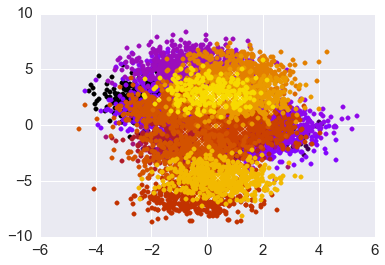

In [4]:
## plot the first two dimensions
centroids = data[np.random.choice(range(data.shape[0]), k, replace=False),:]

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

centroids1 =output_k["Centroids"]
labels1 = output_k["Labels"]

for i,color in enumerate(colors,start =1):
    plt.scatter(data[labels1==i, :][:,0], data[labels1==i, :][:,1], color=color)

for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x')    


### K-Means++

In [1]:
def KMeansPlusPlus(data, k):
    
    """ Apply the KMeans++ clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
    
    Returns:
      "Centroids"                 the final centroids finded by KMeans  
      
    """
    
    n = data.shape[0]
    
    #Initialize the first centroid
    centroids = data[np.random.choice(range(n),1),:]
    
    #broadcast the data sets to calculate the distance conveniently
    data_expand = data[:, np.newaxis, :]
    
    while centroids.shape[0] < k :
        
        #Calculate the distance between 
        pre_distance = (data_expand - centroids) ** 2
        distance = np.sum(pre_distance, axis=2)
        
        #mark the location of minimum distance for every centroid
        min_dist = np.zeros(distance.shape)
        min_dist[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
        
        #Calculate the normal constant of the distribution
        normal_cons = np.sum(distance[min_dist == 1])
        
        #Get the distribution for sampling new centroids
        distribution = np.min(distance, axis=1)/normal_cons
        
        #Obtain the next centroid and append
        centroids = np.r_[centroids, data[np.random.choice(range(n),1,p=distribution), :]]
    
    return centroids

### Kmeans Parallel

In [2]:
def ScalableKMeansPlusPlus(data, k, l):
    
    """ Apply the KMeans|| clustering algorithm
    
    Parameters:
      data                        ndarrays data 
      k                           number of cluster
      l                           number of point sampled in each iteration
    
    Returns:
      "Centroids"                 the final centroids finded by KMeans  
      
    """
    
    centroids = data[np.random.choice(range(data.shape[0]),1), :]
    data_expand = data[:, np.newaxis, :]
    
    #Calculate the iteration times
    pre_distance = (data_expand - centroids) ** 2
    distance = np.sum(pre_distance, axis=2)
    min_dist = np.zeros(distance.shape)
    min_dist[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
    normal_cons = np.sum(distance[min_dist == 1])
    iter = int(np.log(normal_cons))
    
    for i in range(iter):
        pre_distance = (data_expand - centroids) ** 2
        distance = np.sum(pre_distance, axis=2)
        
        #mark the location of minimum distance for every centroid
        min_dist = np.zeros(distance.shape)
        min_dist[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
        
        #Calculate the normal constant of the distribution
        normal_cons = np.sum(distance[min_dist == 1])
        
        #Get the distribution for sampling new centroids
        distribution = np.min(distance, axis=1)/normal_cons
        
        #sample l centers from the distribution
        center = data[np.random.choice(range(distribution.shape[0]),k,p=distribution.ravel()),:]
        
        #append the newly sampled l centers to the original ones
        centroids = np.vstack((centroids, center))
    

    ## reduce k*l to k using KMeans++
    pre_distance = (data_expand - centroids) ** 2
    distance = np.sum(pre_distance, axis=2)
    min_dist = np.zeros(distance.shape)
    min_dist[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
    weights = np.array([np.count_nonzero(min_dist[:, i]) for i in range(centroids.shape[0])]).reshape(-1,1)
    prob_distribution = weights/np.sum(weights)
    centroids = data[np.random.choice(range(weights.shape[0]),k,p=prob_distribution.ravel()),:]
    
    return centroids

In [6]:
l = 10
initial_Kpp = KMeansPlusPlus(data,k)
initial_Kll = ScalableKMeansPlusPlus(data,k,l)

In [7]:
initial_Kll.shape

(20, 15)

## Testing

## Optimization

## High performance computing

## Application and comparison

## Reference

[1] Wu, Xindong, et al. "Top 10 algorithms in data mining." Knowledge and information systems 14.1 (2008): 1-37.

[2] Bahmani, Bahman, et al. "Scalable k-means++." Proceedings of the VLDB Endowment 5.7 (2012): 622-633

[3] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
